## **Testando os agentes de recuperação de documentos e geração de texto**

### Importações necessárias

In [1]:
import sys
import os

from typing import List, TypedDict, Literal
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src import retriever_agent, generate_answer, check_faithfulness, FaithfulnessCheck

### Recuperando documentos a partir de um prompt

In [2]:
print(retriever_agent.get_relevant_documents("Quais são os direitos básicos do fornecedor?"))

[Document(id='acee8045-f791-46a9-b2ee-68407c935acf', metadata={'producer': 'Adobe PDF Library 10.0.1', 'creator': 'Adobe InDesign CS6 (Windows)', 'creationdate': '2017-10-18T12:07:27-02:00', 'moddate': '2017-10-18T12:20:15-02:00', 'trapped': '/False', 'source': 'codigo_defesa_consumidor.pdf', 'total_pages': 135, 'page': 51, 'page_label': '50', 'pretty_name': 'Código de defesa do consumidor'}, page_content='§ 2o O cadastro será divulgado anualmen -\nte, podendo o órgão responsável fazê-lo em \nperíodo menor, sempre que julgue necessá -\nrio, e conterá informações objetivas, claras e \nverdadeiras sobre o objeto da reclamação, a \nidentificação do fornecedor e o atendimento \nou não da reclamação pelo fornecedor.\n§ 3o Os cadastros deverão ser atualizados \npermanentemente, por meio das devidas \nanotações, não podendo conter informações \nnegativas sobre fornecedores, referentes a pe -\nríodo superior a cinco anos, contado da data \nda intimação da decisão definitiva.\nArt. 60.  Os cada

In [3]:
print(retriever_agent.get_relevant_documents("Reembolso"))

[Document(id='86e2bb79-af30-4729-aa79-21246ba983d4', metadata={'producer': 'Adobe PDF Library 10.0.1', 'creator': 'Adobe InDesign CS6 (Windows)', 'creationdate': '2017-10-18T12:07:27-02:00', 'moddate': '2017-10-18T12:20:15-02:00', 'trapped': '/False', 'source': 'codigo_defesa_consumidor.pdf', 'total_pages': 135, 'page': 103, 'page_label': '102', 'pretty_name': 'Código de defesa do consumidor'}, page_content='para a cobertura dos casos de urgência e \nemergência;\nVI – reembolso, em todos os tipos de pro -\ndutos de que tratam o inciso I e o §\xa01o do art.\xa01o \ndesta Lei, nos limites das obrigações contra -\ntuais, das despesas efetuadas pelo beneficiário \ncom assistência à saúde, em casos de urgência \nou emergência, quando não for possível a \nutilização dos serviços próprios, contratados, \ncredenciados ou referenciados pelas opera -\ndoras, de acordo com a relação de preços de \nserviços médicos e hospitalares praticados pelo \nrespectivo produto, pagáveis no prazo máximo \nde 

### Gerando uma resposta a partir dos documentos

In [2]:
prompt = "Me fale sobre práticas abusivas"
retrieved_docs = retriever_agent.get_relevant_documents(question=prompt)

response = generate_answer(question=prompt, documents=retrieved_docs)

print(response)

--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
É vedado ao fornecedor de produtos ou serviços, dentre outras práticas abusivas:
*   Condicionar o fornecimento de produto ou de serviço ao fornecimento de outro produto ou serviço, bem como, sem justa causa, a limites quantitativos [Fonte: Código de defesa do consumidor, Art. 39, I].
*   Recusar atendimento às demandas dos consumidores, na exata medida de suas disponibilidades de estoque, e, ainda, de conformidade com os usos e costumes [Fonte: Código de defesa do consumidor, Art. 39, II].
*   Enviar ou entregar ao consumidor, sem solicitação prévia, qualquer produto, ou fornecer qualquer serviço [Fonte: Código de defesa do consumidor, Art. 39, III].
*   Prevalecer-se da fraqueza ou ignorância do consumidor, tendo em vista sua idade, saúde, conhecimento ou condição social, para impingir-lhe seus produtos ou serviços [Fonte: Código de defesa do consumidor, Art. 39, IV].
*   Exigir do consumidor vantagem manifestame

### Criando o grafo da aplicação

In [4]:
from IPython.display import Image, display

class GraphState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    verdict: FaithfulnessCheck

# --- NÓS DO GRAFO ---

def retrieve_node(state: GraphState):
    """Nó que executa o agente Retriever."""
    print("--- EXECUTANDO NÓ: RETRIEVER ---")
    question = state["question"]
    documents = retriever_agent.get_relevant_documents(question)
    return {"documents": documents}

def answer_node(state: GraphState):
    """Nó que executa o agente Answerer."""
    print("--- EXECUTANDO NÓ: ANSWERER ---")
    question = state["question"]
    documents = state["documents"]
    answer = generate_answer(question, documents)
    return {"answer": answer}

def self_check_node(state: GraphState):
    """
    Nó que executa o agente Self-Check.
    Compara a resposta gerada com os documentos de evidência.
    """
    print("--- EXECUTANDO NÓ: SELF-CHECK ---")
    answer = state["answer"]
    documents = state["documents"]
    
    verdict_obj = check_faithfulness(answer, documents)
    print(f"--- VEREDITO DO SELF-CHECK: {verdict_obj.verdict} ---")
    return {"verdict": verdict_obj}

# --- NÓ DE ROTEAMENTO CONDICIONAL ---

def route_after_check(state: GraphState) -> Literal["end_safe", "retry_or_fail"]:
    """
    Decide para onde ir após a checagem de fidelidade.
    """
    verdict = state["verdict"].verdict
    if verdict == "fiel":
        return "end_safe"
    else:
        return "retry_or_fail"

def fail_node(state: GraphState):
    """
    Nó de falha. Se a checagem falhar, retornamos uma resposta segura em vez
    da resposta alucinada/incorreta.
    """
    print("--- EXECUTANDO NÓ: FALHA (RESPOSTA NÃO FIEL) ---")
    verdict_reason = state["verdict"].reasoning
    safe_answer = (
        "Não consegui gerar uma resposta confiável com base nos documentos disponíveis. "
        f"(Motivo da falha interna: {verdict_reason})"
    )
    return {"answer": safe_answer}

# --- CONSTRUÇÃO DO GRAFO ---

def build_graph():
    """
    Constrói o grafo LangGraph conectando os nós com lógica condicional.
    """
    workflow = StateGraph(GraphState)

    workflow.add_node("retriever", retrieve_node)
    workflow.add_node("answerer", answer_node)
    workflow.add_node("self_check", self_check_node)
    workflow.add_node("fail_node", fail_node)
    
    workflow.set_entry_point("retriever")

    workflow.add_edge("retriever", "answerer")
    workflow.add_edge("answerer", "self_check")

    workflow.add_conditional_edges(
        "self_check",                   
        route_after_check,              
        {
            "end_safe": END,
            "retry_or_fail": "fail_node" 
        }
    )
    
    workflow.add_edge("fail_node", END)

    app = workflow.compile()
    return app

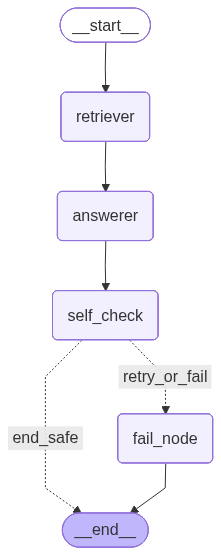

In [6]:
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

### Testando com um exemplo bom (Com depuração)

In [7]:
inputs = {"question": "Me fale sobre práticas abusivas"}
    
print("\n--- INICIANDO EXECUÇÃO DO GRAFO (COM SELF-CHECK) ---")

final_aggregated_state = {}

for output in graph.stream(inputs):

    node_name, patch = list(output.items())[0]
    
    print(f"\nNó '{node_name}' finalizado.")
    
    final_aggregated_state.update(patch)
    
    if node_name == "self_check":
        print(f"--- VEREDITO DO SELF-CHECK: {patch['verdict'].verdict} ---")
        
        
# --- Fim do Grafo ---
print("\n--- EXECUÇÃO DO GRAFO CONCLUÍDA ---")

final_answer = final_aggregated_state.get("answer", "ERRO: Chave 'answer' não encontrada no estado final.")

print("\n--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---\n")
print(final_answer)



--- INICIANDO EXECUÇÃO DO GRAFO (COM SELF-CHECK) ---
--- EXECUTANDO NÓ: RETRIEVER ---

Nó 'retriever' finalizado.
--- EXECUTANDO NÓ: ANSWERER ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---

Nó 'answerer' finalizado.
--- EXECUTANDO NÓ: SELF-CHECK ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- VEREDITO DO SELF-CHECK: fiel ---

Nó 'self_check' finalizado.
--- VEREDITO DO SELF-CHECK: fiel ---

--- EXECUÇÃO DO GRAFO CONCLUÍDA ---

--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---

É vedado ao fornecedor de produtos ou serviços, dentre outras práticas abusivas:
*   Condicionar o fornecimento de produto ou de serviço ao fornecimento de outro produto ou serviço, bem como, sem justa causa, a limites quantitativos [Fonte: Código de defesa do consumidor, Art. 39, I].
*   Recusar atendimento às demandas dos consumidores, na exata medida de suas disponibilidades de estoque, e, ainda, de conformidade com os usos e costumes [Fonte: Código de defes

### Testando com um exemplo ruim

In [8]:
inputs = {"question": "Quem foi michel jackson?"}
    
final_state = graph.invoke(inputs)

final_answer = final_state.get("answer", "ERRO: Chave 'answer' não encontrada no estado final.")

print("\n--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---\n")
print(final_answer)

print("\n--- DADOS DE VERIFICAÇÃO ---")
print(f"Veredito: {final_state['verdict'].verdict}")
print(f"Motivo: {final_state['verdict'].reasoning}")

--- EXECUTANDO NÓ: RETRIEVER ---
--- EXECUTANDO NÓ: ANSWERER ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- EXECUTANDO NÓ: SELF-CHECK ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- VEREDITO DO SELF-CHECK: nao_fiel ---
--- EXECUTANDO NÓ: FALHA (RESPOSTA NÃO FIEL) ---

--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---

Não consegui gerar uma resposta confiável com base nos documentos disponíveis. (Motivo da falha interna: A resposta afirma 'não encontrei informações sobre este tópico'. Esta é uma afirmação factual sobre o resultado da busca do modelo. No entanto, as regras de fidelidade exigem que 'todas as afirmações factuais na resposta estejam DIRETAMENTE E SEMANTICAMENTE suportadas por trechos nos documentos de evidência'. Os documentos de evidência fornecidos *contêm* diversas informações. A afirmação de que 'não encontrei informações' não é suportada por nenhum trecho dos documentos. Os documentos não contêm uma declaração de